In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"
from diffusers import DiffusionPipeline
import numpy as np
import random
import torch
from diffusers import StableDiffusionPipeline
import glob
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union

from fid.fid_score import calculate_activation_statistics, save_statistics, load_statistics, calculate_frechet_distance, get_activations
from fid.inception import InceptionV3

from PIL import Image
from tqdm.auto import tqdm
from torch import autocast

from utils.visualise import image_grid, latent_to_img, decode_latent, output_to_img
from schedulers.euler_discrete import EulerDiscreteCustomScheduler, FrozenDict, randn_tensor
from utils.score_utils import get_sigmas, get_score_input, scale_input, get_score, step_score, langevin_step, repulsive_term, denoise

In [2]:
# Using 512x512 resolution
model_id = "stabilityai/stable-diffusion-2-base"
# model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id)#, torch_dtype=torch.float16)
device = "cuda"
pipe = pipe.to(device)
pipe.safety_checker = None

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 8821.54it/s]


In [25]:
# Settings
prompt = ["a black cat"]
config = {
    "pipe": pipe,
    "height": 512,
    "width": 512,
    "num_inference_steps": 20,
    "num_train_timesteps": 1000,
    "batch_size": 1,
    "cfg": 8,
    "beta_start": 0.00085,
    "beta_end": 0.012,
}

# Seeds
seed=1024
generator = torch.Generator("cuda").manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(0)
random.seed(0)

# Noise levels
sigmas, timesteps = get_sigmas(config, device=device)
init_latents, text_embeddings = get_score_input(prompt, config, generator=generator, device="cuda")
config = {**config,
          "sigmas": sigmas,
          "timesteps": timesteps,
          "init_latents": init_latents,
          "text_embeddings": text_embeddings
          }

In [66]:
def langevin_step(
        sample: torch.FloatTensor,
        score,
        generator,
        device="cuda",
    ):
        """Take noisy step towards score - function based off VE shceduler corrector step method"""
        noise = torch.randn(sample.shape, layout=sample.layout, device=device, generator=generator).to(device)

        step_size=0.1
        prev_sample = sample + step_size * score + ((step_size * 2) ** 0.5) * noise
        return prev_sample

def denoise(
    correction_levels,
    correction_steps,
    config,
    return_all_samples=False,
    save_score_norms=False,
    device="cuda",
    ):
    """ Denoising function
        init_latents: Starting latent sample to denoise from
        correction_levels: list of noise levels where langevin steps should be done (towards MAP)
        correction_steps: how many steps to do in each noise level correction_levels
        sigmas: noise level for each timestep
        timestep: associated timesteps to pass to unet
        return_final: return final latent sample, otherwise return list of all samples (save every other latent)
    """
    # standard deviation of the initial noise distribution
    sigmas = config['sigmas']
    latents = config['init_latents'] * sigmas.max()

    if return_all_samples:
        latent_list = [latents]
    score_norm_hist = []
    for i, t in enumerate(tqdm(config['timesteps'])):
        t = t.to(device)
        step_index = (config['timesteps'] == t).nonzero().item()
        sigma = sigmas[step_index]
        
        # Move to next marginal in diffusion
        score = get_score(latents, sigma, t, config)
        latents = step_score(latents, score, sigmas, step_index)
        if return_all_samples and i%2==0:
            latent_list.append(latents)
        
        # Langevin steps
        if i in correction_levels:
            for _ in range(correction_steps):
                score = get_score(latents, sigma, t, config)
                latents = langevin_step(latents, score, generator)

    
    if return_all_samples:
        return latent_list, score_norm_hist
    
    return latents, score_norm_hist

In [ ]:
# Get latent samples from one noise level
# - i.e. throughout langevin steps
# Function to denoise these samples for REMAINING sigmas and timesteps
# - Just truncate sigmas and timesteps (but this is stored in config...,maybe not have in config...)

In [67]:
latent, _ = denoise([0], 100, config, return_all_samples=True)


  0%|          | 0/20 [00:08<?, ?it/s]


KeyboardInterrupt: 

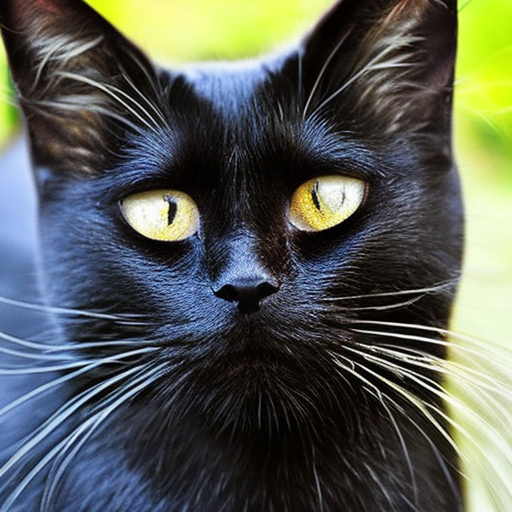

In [65]:
# Plot image results
image = output_to_img(decode_latent(latent, config['pipe'].vae))
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]